In [73]:
import os
import tensorflow as tf
import numpy as np
from PIL import Image, ImageDraw
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os

In [74]:

IMAGE_SIZE = (640, 640)  # Input size for YOLOv8
BATCH_SIZE = 3  # Number of samples per batch
NUM_CLASSES = 1  # Example number of classes, adjust as needed
BOUNDING_BOX_FORMAT = "xywh"  # YOLO bounding box format
PAD_TO_ASPECT_RATIO = True  # To maintain aspect ratio when resizing

In [75]:
# Paths to the datasets
IMAGES_DIR = Path("D:/Projects/DL/MonumentDetection/DL/ultralytics/dataset/images")
LABELS_DIR = Path("D:/Projects/DL/MonumentDetection/DL/ultralytics/dataset/labels")

In [76]:
# Function to load YOLO annotations
def load_yolo_annotations(label_path, image_size):
    annotations = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split(" ")
            if len(parts) != 5:
                continue  # Skip lines that don't match expected format

            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            # Convert normalized "xywh" to pixel-based "xyxy" format
            x_min = (x_center - width / 2) * image_size[0]
            y_min = (y_center - height / 2) * image_size[1]
            x_max = (x_center + width / 2) * image_size[0]
            y_max = (y_center + height / 2) * image_size[1]

            annotations.append([x_min, y_min, x_max, y_max, class_id])

    return np.array(annotations, dtype=np.float32)

In [77]:

# Function to load image and corresponding annotations
def load_sample(image_path, labels_dir):
    image_path_str = tf.keras.backend.get_value(image_path).decode("utf-8")  # Convert tensor to string
    image = Image.open(image_path_str).resize(IMAGE_SIZE)  # Resize to 640x640
    image = np.array(image) / 255.0  # Normalize
    
    # Construct the label path and validate its existence
    image_stem = Path(image_path_str).stem
    label_path = os.path.join(labels_dir, image_stem + ".txt")

    if not os.path.isfile(label_path):
        raise FileNotFoundError(f"Label file not found: {label_path}")

    # Load YOLO annotations
    annotations = load_yolo_annotations(label_path, IMAGE_SIZE)  # Load annotations
    return image, annotations

In [78]:

# Function to separate class IDs from bounding box coordinates
def extract_bounding_box_info(bounding_boxes_raw):
    # Check if the last dimension has five elements
    if bounding_boxes_raw.shape[-1] == 5:
        # Extract the class ID (last element) and bounding box coordinates
        class_ids = bounding_boxes_raw[..., -1]  # The last element is the class ID
        bounding_boxes = bounding_boxes_raw[..., :-1]  # The rest is the bounding box coordinates
    else:
        raise ValueError(f"Unexpected bounding box shape: {bounding_boxes_raw.shape}")
    return bounding_boxes, class_ids

In [79]:
# Function to filter out empty annotations
def filter_empty_annotations(image, annotations):
  return tf.size(annotations) > 0  # Check if there are any annotations

In [80]:
def pad_annotations(image, annotations, max_annotations_row=1, max_annotations_col=4):
    rows = 1 # Number of rows we are considering in our reshaping 
    cols = 4 # Number of cols we are considering in our reshaping
    
    # Get the number of annotations
    num_annotations_row = tf.shape(annotations)[0]
    num_annotations_col = tf.shape(annotations)[1]

    # Reshape the annotations to ensure it has the shape [1,5]
    # retreive tensor shape that represents the shape of "annotations", then extract
    # the size of the first dimension
    annotations = tf.reshape(annotations, [rows, 5])

    #Calculate the padding required to match max_annotations
    # padding is a list of lists, where each inner list defines how much padding
    # to add for each dimension. 
    # Here, we pad the first dimension and not the second 
    # How much elements to add to create "max_annotations" in our case, 1 row
    padding = [[0, max_annotations_row - num_annotations_row], [0,0]]
    annotations = tf.pad(annotations, padding, constant_values=-1)

    # sess = tf.compat.v1.Session()
    # annotations = sess.run(annotations)

    # annotations = np.array(annotations)
    
    # extracts specific column from the annotations tensor. 
    #:,0 extracts all rows and first column
    classes = tf.expand_dims(annotations[:, 0], axis=-1)
    boxes = annotations[:, 1:]
    # # classes = annotations[:, 0]
    # boxes = annotations[:, 1:]
    
    return image, {'classes': classes, 'boxes': boxes}

In [81]:
def data_loader(images_dir, labels_dir, batch_size):
    image_paths = list(Path(images_dir).rglob("*.jpg")) + list(Path(images_dir).rglob("*.png"))

    if len(image_paths) == 0:
        raise ValueError(f"No images found in {images_dir}. Check your dataset path.")

    dataset = tf.data.Dataset.from_tensor_slices([str(p) for p in image_paths])

    def load_sample_with_shape(image_path):
        image, annotations = tf.py_function(
            lambda y: load_sample(y, labels_dir),
            [image_path],
            [tf.float32, tf.float32]
        )
        image.set_shape(IMAGE_SIZE + (3,))
        annotations.set_shape([None, 5])
        return image, annotations

    dataset = dataset.map(load_sample_with_shape, num_parallel_calls=tf.data.AUTOTUNE)

    # def resize_with_shape(image, annotations):
    #     image, annotations = tf.py_function(
    #         func=lambda img, ann: inference_resizing(img, ann),
    #         inp=[image, annotations],
    #         Tout=[tf.float32, tf.float32]
    #     )
    #     image.set_shape([640, 640, 3])
    #     annotations.set_shape([None, 5])
    #     return image, annotations

    # dataset = dataset.map(resize_with_shape, num_parallel_calls=tf.data.AUTOTUNE)

    # def normalize_with_shape(image, annotations):
    #     image, annotations = tf.py_function(
    #         func=lambda img, ann: (normalize_image_data(img), ann),
    #         inp=[image, annotations],
    #         Tout=[tf.float32, tf.float32]
    #     )
    #     image.set_shape([640, 640, 3])
    #     annotations.set_shape([None, 5])
    #     return image, annotations

    # dataset = dataset.map(normalize_with_shape, num_parallel_calls=tf.data.AUTOTUNE)

    # def ensure_rgb_with_shape(image, annotations):
    #     image, annotations = tf.py_function(
    #         func=lambda img, ann: (ensure_rgb_format(img), ann),
    #         inp=[image, annotations],
    #         Tout=[tf.float32, tf.float32]
    #     )
    #     image.set_shape([640, 640, 3])
    #     annotations.set_shape([None, 5])
    #     return image, annotations

    # dataset = dataset.map(ensure_rgb_with_shape, num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.filter(lambda image, annotations: tf.py_function(
        func=filter_empty_annotations,
        inp=[image, annotations],
        Tout=tf.bool)
    )

    # dataset = dataset.map(lambda image, annotations: pad_annotations(image, annotations))

    dataset = dataset.batch(batch_size, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

    return dataset

In [82]:
# Create datasets for training, validation, and testing
dataset = data_loader(IMAGES_DIR, LABELS_DIR, BATCH_SIZE)

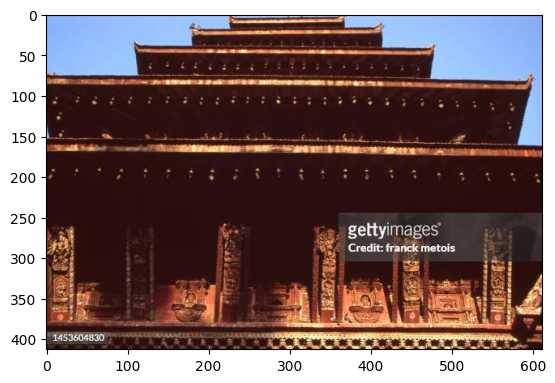

In [83]:
%matplotlib inline
img = Image.open(Path("D:/Projects/DL/MonumentDetection/DL/dataset/train/images/1c2822e4-image_480.png"))
img = np.asarray(img)
imgplot = plt.imshow(img)

In [96]:
def visualize_image_with_bboxes(image, boxes, class_labels, bbox_color='red', bbox_width=2):
    """
    Visualize an image with bounding boxes and class labels.
    
    Parameters:
    - image: Tensor image.
    - boxes: List of bounding boxes.
    - class_labels: List of class labels corresponding to bounding boxes.
    - bbox_color: Color of the bounding box.
    - bbox_width: Width of the bounding box line.
    """
    # Convert Tensor image to PIL Image
    image_np = (image.numpy() * 255).astype('uint8')
    image_pil = Image.fromarray(image_np)
    draw = ImageDraw.Draw(image_pil)

    for box, label in zip(boxes, class_labels):
        xmin, ymin, xmax, ymax = box.numpy()
        
        if (ymax - ymin) > 0 and (xmax - xmin) > 0:
            draw.rectangle([xmin, ymin, xmax, ymax], outline=bbox_color, width=bbox_width)
            draw.text((xmin, ymin), str(int(label)), fill=bbox_color)

    return image_pil


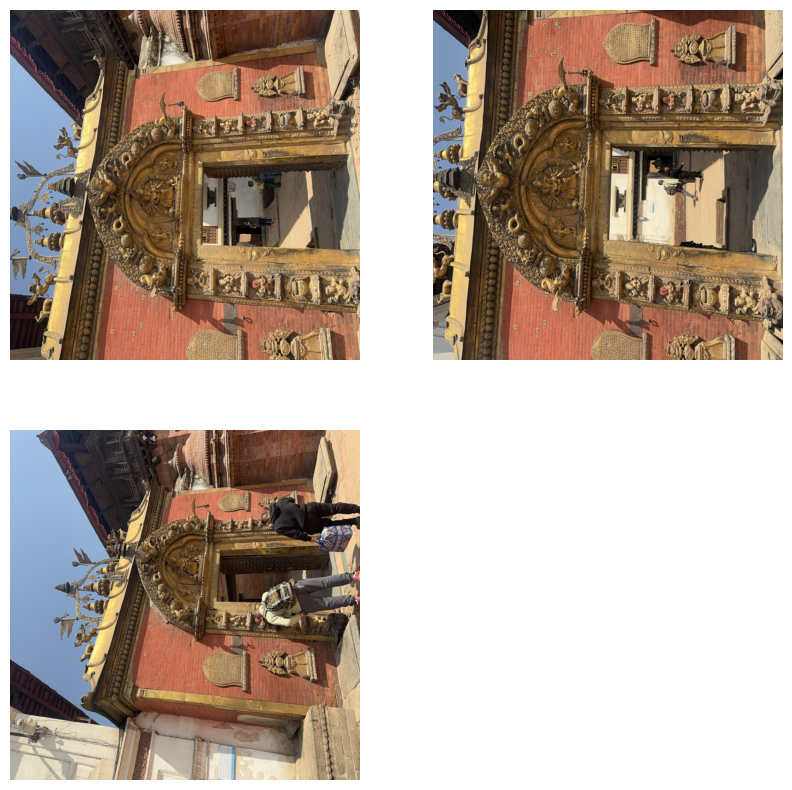

valid_classes:  tf.Tensor([1.], shape=(1,), dtype=float32)
valid_boxes:  tf.Tensor([[  2.7482555   4.122383  640.        640.       ]], shape=(1, 4), dtype=float32)
valid_indices:  tf.Tensor([[0]], shape=(1, 1), dtype=int64)
valid_classes:  tf.Tensor([1.], shape=(1,), dtype=float32)
valid_boxes:  tf.Tensor([[  4.122383  12.367149 640.       638.9694  ]], shape=(1, 4), dtype=float32)
valid_indices:  tf.Tensor([[0]], shape=(1, 1), dtype=int64)
valid_classes:  tf.Tensor([1.], shape=(1,), dtype=float32)
valid_boxes:  tf.Tensor([[105.80784   52.560387 548.277    610.11273 ]], shape=(1, 4), dtype=float32)
valid_indices:  tf.Tensor([[0]], shape=(1, 1), dtype=int64)


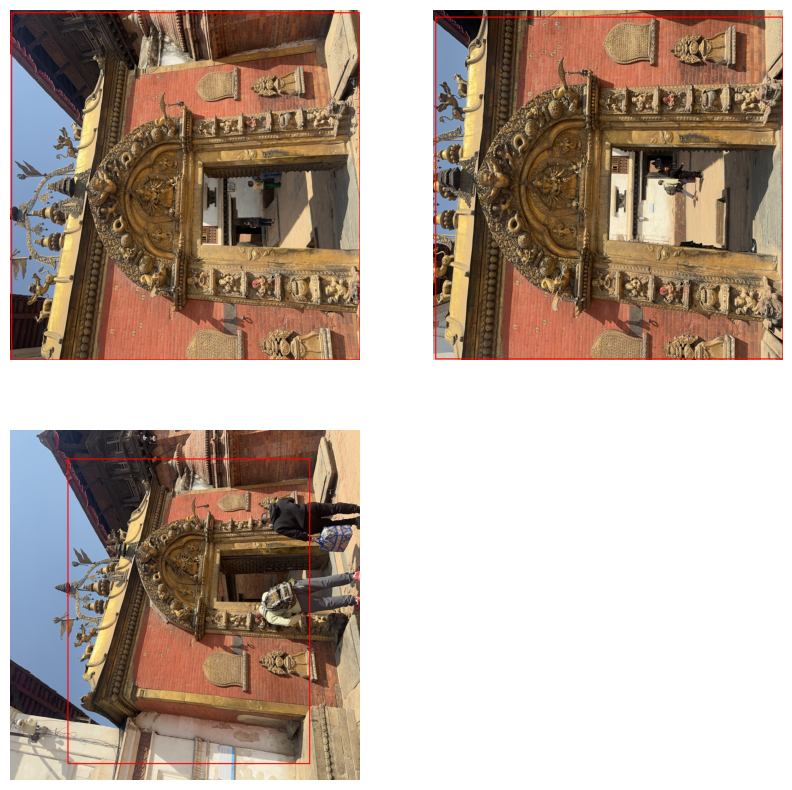

In [97]:
for batch in dataset.take(1):  # Take the first batch
    images = batch[0]  # Assuming images are the first element
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(images):
        plt.subplot(2, 2, i + 1)  # Assuming only 1 image in the batch
        plt.imshow(image.numpy())
        plt.axis('off')
    plt.show()


for batch in dataset.take(1):
    images = batch[0]
    ground_truths = batch[1].numpy()
    plt.figure(figsize=(10, 10))
    # print("ground_truths: ", ground_truths)
    boxes = ground_truths[:, :, :4]
    # print("boxes: ", boxes)
    class_labels = ground_truths[:, :, 4]
    # class_labels = ground_truths[:, :, 1:]
    # boxes = ground_truths['boxes']
    # class_labels = ground_truths['classes']

    for i, (image, box, class_label) in enumerate(zip(images, boxes, class_labels)):
        plt.subplot(2, 2, i + 1)

        # Filter out invalid boxes
        valid_indices = tf.where(box[:, 2] > box[:, 0])  # Ensuring xmax > xmin
        valid_boxes = tf.gather(box, valid_indices[:, 0])
        valid_classes = tf.gather(class_label, valid_indices[:, 0])
        print("valid_classes: ", valid_classes)
        print("valid_boxes: ", valid_boxes)
        print("valid_indices: ", valid_indices)
        # num_valid_boxes = valid_boxes.shape[0]

        image_with_bboxes = visualize_image_with_bboxes(image, valid_boxes, valid_classes)
        image_with_bboxes = np.array(image_with_bboxes)
        plt.imshow(image_with_bboxes)
        plt.axis("off")
        
    plt.show()